# Yield Analysis in Semiconductor Manufacturing Process
<br><br>
<div style="text-align: justify">
A complex modern semiconductor manufacturing process is normally under consistent monitoring of signals/variables collected from sensors and process measurements. However, not all of these signals are equally valuable in a specific monitoring system. The measured signals contain a combination of useful information, irrelevant information as well as noise. It is often the case that useful information is buried in the later two. Engineers typically have a much larger number of signals than are actually required. If we consider each type of signal as a feature, then feature selection may be applied to identify the most relevant signals. The Process Engineers may then use these signals to determine key factors contributing to yield excursions downstream in the process. This will enable an increase in process throughput, decreased time to learning and reduce the per unit production costs.

<br><br>
<img src="process.gif"  width="40%">  
<div style="text-align: center"> Figure 1. [Basic Semiconductor Manufacturing Process](http://blog.associatie.kuleuven.be/danhuayao/introduction-of-the-metallic-contamination/)</div> 
<br>


In this project, <b>[SECOM](http://archive.ics.uci.edu/ml/datasets/secom)</b> data-set is first screened in order to identify effective parameters on semiconductor production yield. Then, more analysis is conducted to bring more insight from the data and recommend optimization potential throughout the process. At the end, machine learning technique is used to develop a data-driven model for yield prediction at final stage of fabrication, based on operation data and sensor measurements gathered throughout the process. This notebook is organized as follows: </div>




# Table of Contents

<b>
1. [Data-Set Description](#DSD)
2. [Dimension Reduction](#DR)
3. [Exploratory Data Analysis (EDA)](#EDA)
4. [Statistical Analysis & Hypothesis Testing](#SAHT)
5. [Time Series Analysis](#TSA)
6. [Imbalanced Data](#ID)
7. [Machine Learning Model Development](#MLMD)
8. [XGB Model Optimization](#XGBMO)
9. [Final Note](#FN)
</b>


<br>
<a id="DSD"></a>
### 1- Data-Set Description 
<div style="text-align: justify">
The SECOM data-set comes in 2 separate files. "secom_data", which is consisting of 1567 examples each with 591 features a 1567 x 591 matrix and "secom_labels", which is containing the classification labels and date time stamp for each example.
Each example represents a single production entity with associated measured features and the labels represent a simple pass/fail yield for in house line testing and associated date time stamp. Where –1 corresponds to a pass and 1 corresponds to a fail and the data time stamp is for that specific test point. The SECOM data-set is anonymized, which results in no feature identification. In addition, all categorical data is converted to numerical value. <div> 

In [2]:
# Import libraries and Packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

%matplotlib inline

###########################################################

# Loading Data-Set
label = pd.read_csv("/Users/Mahyar/SECOM/secom_labels.txt", delim_whitespace=True, header=None)
features = pd.read_csv("/Users/Mahyar/SECOM/secom_data.txt", delim_whitespace=True,header=None)

features = features.rename(columns={features.columns[i]: 'F'+ str(i) for i in range (590)}) # adding name to feature columns
label = label.rename(columns={0: 'L0', 1 :'date'})   # adding name to label column

############################################################

# Concatinating to separate files
df = pd.concat([features,label],axis=1, ignore_index=False)
#print(df.head()) # Preliminary inspection of data-set
#print(df.shape) # Preliminary inspection of data-set
#print(df.index) # Preliminary inspection of data-set

# Dropping columns with more than 10% missing data
df = df.dropna(thresh=len(df) - int(0.1 * len(df)), axis=1)
df = df.fillna(df.median())
df.L0.replace(-1,0, inplace=True) # Converting label column to binary [0,1]

# Building label vectore (y) and feature matrix(X)
y = df['L0']
X = df.drop(['L0','date'], axis=1)

<a id="DR"></a>
### 2- Dimension Reduction
<div style="text-align: justify">
As mentioned earlier, there are 591 features collected for each product, but only fraction of them are really significant in yield analysis and the rest are trivial or correlated. One way to reduce the dimension of unnecessary data is to employ Lasso regularization technique. This technique identifies feature significance based on its variance. Therefore, features with smaller variances (less significant) will vanish over the course of regularization. Using this technique decreases number of features and usually considered as a first step in feature selection.   

<br>
<img src="LASSO-01.png"  width="40%"> 
<br>

In LASSO regularization technique, by tuning alpha (regularization rate) one can determine how many features to remain in the data-set. It is recommended to examine range of regularization rates to reach the optimal value. As shown above, in current case alpha = 0.2 is chosen as the optimal value, which results in drastic reduction in number of features from 591 to 41! <div>

In [5]:
# Employing Lasso regularization approach to reduce feature matrix dimenssion
lasso = Lasso(alpha=0.2,normalize=False)
lasso_coef = lasso.fit(X, y).coef_
print('Total number of remaining features:')
print(len(lasso_coef[lasso_coef!=0.0]))

# Making a list from selected features
val = lasso_coef[lasso_coef!=0.0]
key, = np.where(lasso_coef!=0.0)
feature_list = X.columns[key]
val_plt = np.multiply(val,1000)
feature_list = feature_list.tolist()
feature_column = key.tolist()
val = val.tolist()
print('List of selected features via Lasso dimenssion reduction:')
print(feature_list)

# revising feature matrix based on LASSO features reduction
X = X[feature_list]

Total number of remaining features:
41
List of selected features via Lasso dimenssion reduction:
['F0', 'F1', 'F3', 'F21', 'F22', 'F23', 'F24', 'F59', 'F67', 'F88', 'F90', 'F137', 'F140', 'F159', 'F160', 'F161', 'F162', 'F188', 'F296', 'F297', 'F363', 'F418', 'F419', 'F423', 'F433', 'F468', 'F480', 'F482', 'F483', 'F484', 'F485', 'F486', 'F488', 'F489', 'F499', 'F500', 'F510', 'F511', 'F521', 'F572', 'F589']


<a id="EDA"></a>
### 3- Exploratory Data Analysis (EDA)
<div style="text-align: justify">
We start exploring selected features by making correlation coefficient pair plot. As shown below, there are few correlated features in remaining data-set. If our desired machine learning technique is prone to correlated data then this issue needs to be addressed before feeding data to the ML model. But more importantly, this plot shows no significant correlation between any of these features and final label column. This observation can raise concern that the collected data might not be a good descriptor of the final label. <div> 

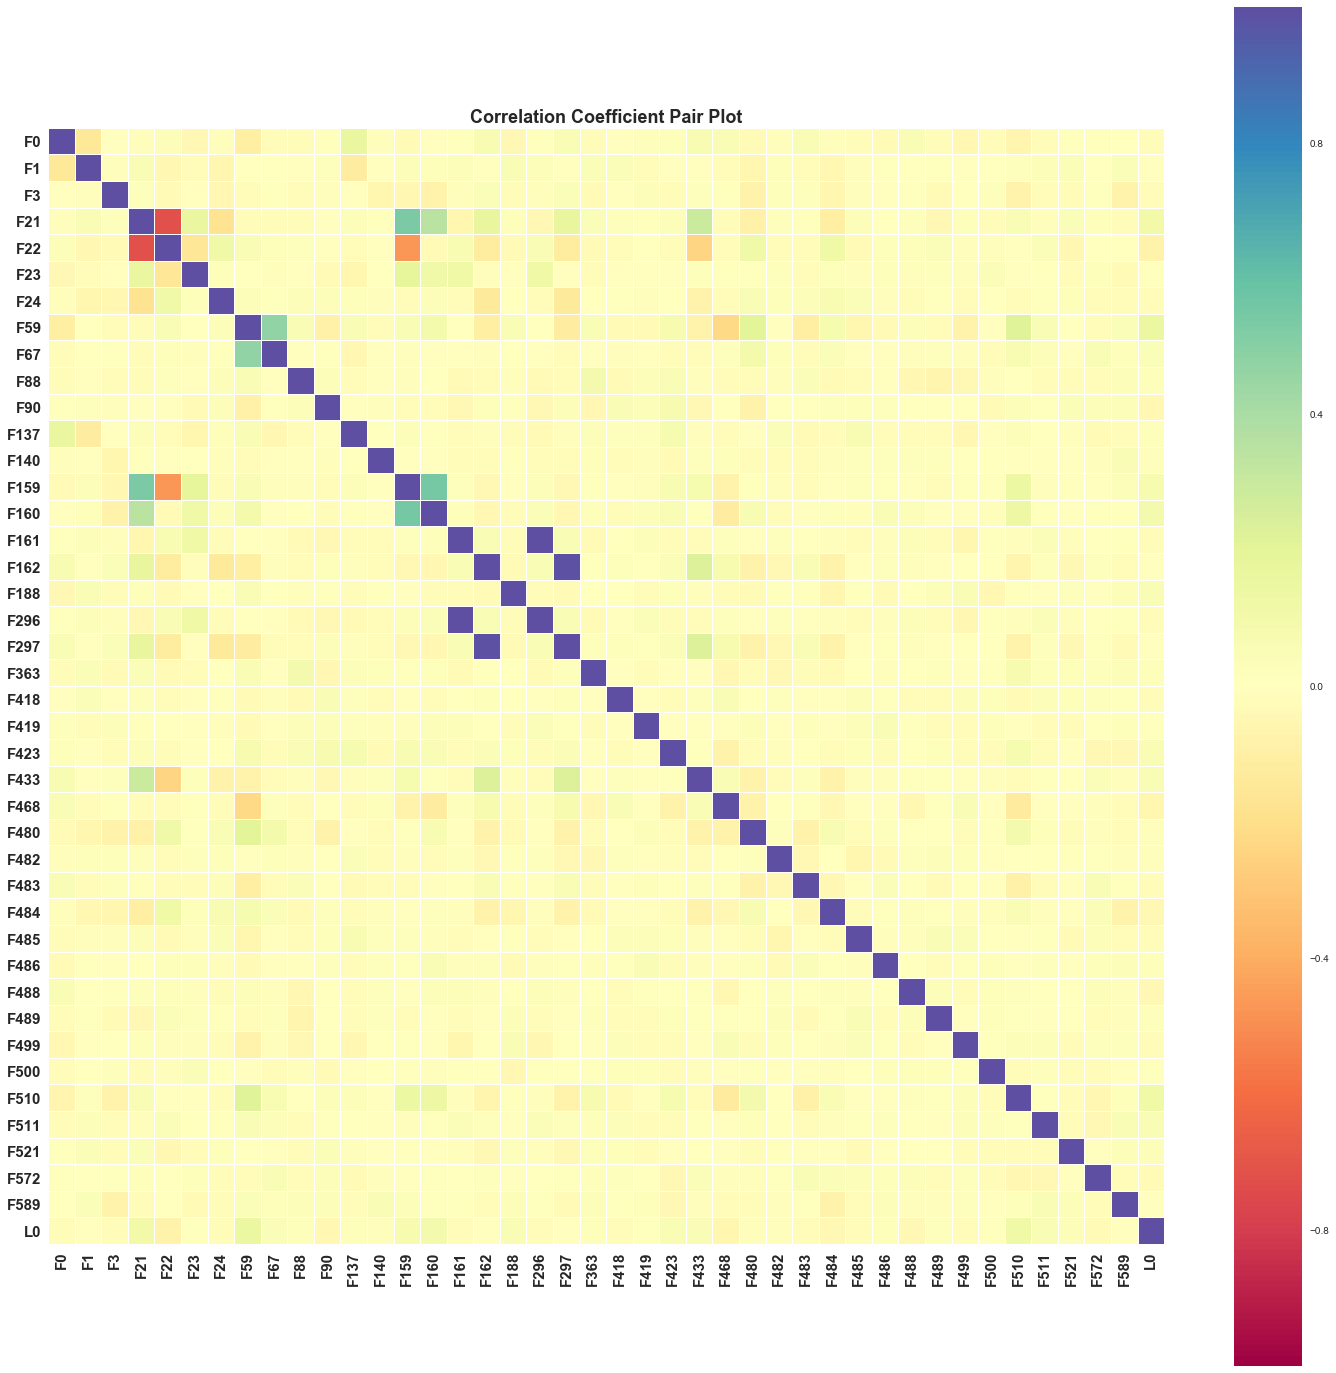

In [8]:
# Making correlation coefficients pair plot of all feature in order to identify degenrate features
plt.figure(figsize=(25,25))
df1 = pd.concat([X,y],axis=1, ignore_index=False) 
ax = plt.axes()
corr = df1.corr()
sns.heatmap(corr, vmax=1,vmin=-1, square=True, annot=False, cmap='Spectral',linecolor="white", linewidths=0.01, ax=ax)
plt.xticks(rotation=90,fontweight="bold", size=15) 
plt.yticks(rotation=0,fontweight="bold", size=15) 
plt.title('Correlation Coefficient Pair Plot', fontweight="bold", size=18)
plt.savefig('pcp.png')
plt.show()

<div style="text-align: justify">
Understanding data variations and outliers is the next step in exploratory data analysis. Box plot can visually represent both concepts in a concise way. As it is evident, some of these features vary couple order of magnitudes and almost all of them suffer from outliers. These are significant issues which needs to be considered later on. Unfortunately because of the anonymity of data-set, it is very difficult to understand nature of these outliers, in order to address them accordingly. It is very important that in model selection take all these factors into account. <div>

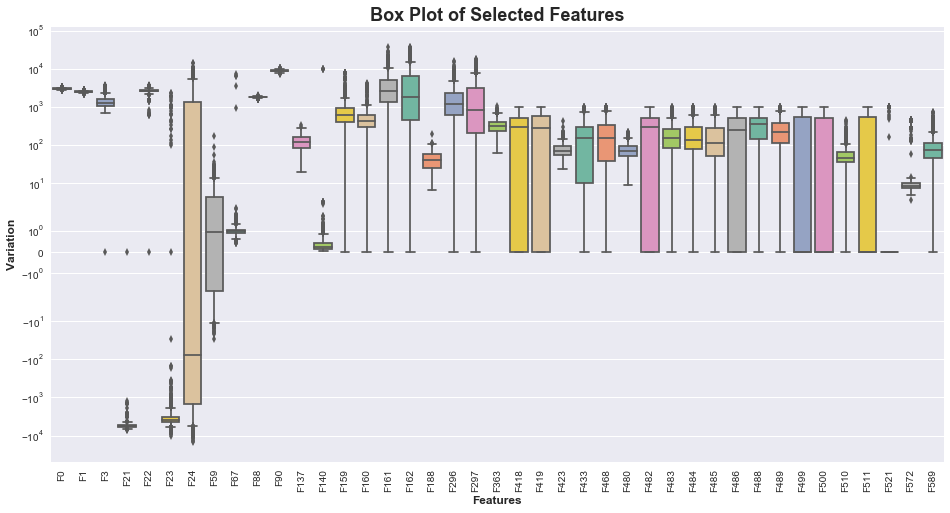

In [9]:
# Making box plot to explore features variations and outliers
plt.figure(figsize=(16,8))
sns.set()
sns.boxplot(data=X, orient="v", palette="Set2")
plt.xlabel('Features',fontweight="bold", size=12)
plt.ylabel('Variation',fontweight="bold", size=12)
plt.title('Box Plot of Selected Features', fontweight="bold", size=18)
plt.yscale('symlog', nonposy='clip')
plt.xticks(rotation=90)
plt.savefig('BoxPlot.png');plt.show()

In [5]:
# Exploratory Data Analysis
# Plotting total products against failed product in histogram format  
bins = 30
for feature in feature_list:
    tf = feature
    plt.figure()
    plt.hist(df1[tf], bins = bins, color='m',label = 'Total',alpha=0.5)
    plt.hist(df1[tf][df1['L0'] == 1], bins = bins, color='b',label = 'Fail')

    plt.xlabel(tf);plt.ylabel('Production')
    plt.title('Feature ID:'+tf,fontweight="bold", size=12)
    plt.yscale('log')

    plt.legend();plt.savefig(tf+'.png');
    plt.close();


<div style="text-align: justify">
To conduct further analysis, histogram of total and fail production for each selected feature was plotted. Quick survey of results reveals 3 different pattern in fail distribution over entire production.

* #### Category I : Uniform Distribution of Pass & Fail
<img src="F488.png"  width="40%"> 
<div style="text-align: center"> **Example of Category I : Uniform Distribution of Pass & Fail**<div>
<br>

These are normal features with uniform distribution of both classes and can be used in predictive model development. 
<br>
<br>
* #### Category II : Non-uniform, Low Occurrence 
<img src="F67.png"  width="40%"> 
<div style="text-align: center"> **Example of Category II : Non-uniform, Low Occurrence** <div> 
<br>

In this category, production was not uniformly distributed throughout the feature variation. The majority of operation has been carried out at particular values and only tiny fraction occurred outside that zone. These features, probably made it through the list because of the outliers not meaningful variation. In final feature selection, this category can be dropped.
<br>
<br>
* #### Category III : Non-Uniform Distribution of Pass & Fail
<img src="F484.png"  width="40%"> 
<div style="text-align: center"> **Example of Category III : Non-Uniform Distribution of Pass & Fail** <div>
<br>

This category shows non-uniform distribution of pass & fail samples. For features in this category, there are substantial range of values with relatively low failure rate. Therefore, these features are prime candidates for further process optimization. To take this to the next step, one needs first conduct hypothesis testing to figure out if these low failure rate is statistically significant and if true, incorporate more domain expertise to address the issue in real world operation. <div>
<br>

<a id="SAHT"></a>
### 4- Statistical Analysis & Hypothesis Testing
<div style="text-align: justify">
PPrevious section showed that if some features subscribe to certain features, there might be significant difference in yield. However, visualization is not enough and it is necessary to statistically test this hypothesis. Here, F484, which has been highlighted in previous section, is examined as an example. <div>

Higher fail ratio: 0.069
Lower fail ration: 0.025
Ratio difference: 0.044


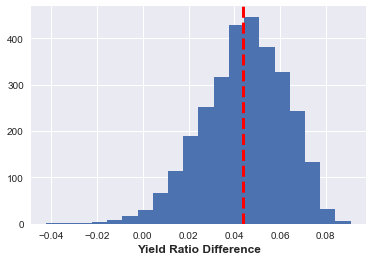

Mean ratio decrease: 0.044
95% Confidence interval: [ 0.0062393   0.07537012]
P-value: 0.525666666667


In [10]:
# Statistical Analysis & Hypothesis Testing
num_replica = 3000
bs_replica = np.empty(num_replica)
ht_feature = 'F484'
threshold = 680

lower_range = df1[(df1[ht_feature]>threshold) ]
higher_range = df1[(df1[ht_feature]<=threshold)]

lower_range_ratio = len(lower_range[lower_range['L0'] == 1])/len(lower_range)
higher_range_ratio = len(higher_range[higher_range['L0'] == 1])/len(higher_range)
ratio_diff = higher_range_ratio-lower_range_ratio

print('Higher fail ratio:',"%.3f" % higher_range_ratio)
print('Lower fail ration:',"%.3f" % lower_range_ratio)
print('Ratio difference:', "%.3f" % ratio_diff)

# Bootstrapping
for i in range(num_replica):
    lr_bs = lower_range.sample(frac=1,replace=True)
    hr_bs = higher_range.sample(frac=1,replace=True)
    
    lr_bs_r = len(lr_bs[lr_bs['L0'] == 1])/len(lr_bs)
    hr_bs_r = len(hr_bs[hr_bs['L0'] == 1])/len(hr_bs)
    ratio_diff_bs = hr_bs_r - lr_bs_r
    bs_replica[i] = ratio_diff_bs  


# Histogram plot    
plt.hist(bs_replica, bins=20)
plt.axvline(ratio_diff, color='r', linestyle='dashed', linewidth=3)
plt.xlabel('Yield Ratio Difference',fontweight="bold", size=12)
plt.show()   

# Calculating P-value
print('Mean ratio decrease:',"%.3f" % np.mean(bs_replica))
print('95% Confidence interval:', (np.percentile(bs_replica,[2.5,97.5])))
print('P-value:', np.sum(bs_replica > (ratio_diff))/num_replica)


<div style="text-align: justify">
High value of P-value (0.54) indicates that the difference in yield before and after F484's threshold (dash red line) is significant. In this case, at least 54% of statistically simulated results show 63% or more decrease in failed ratio if operation can take place after designated threshold, hence this feature can be considered as an optimization point for further actions.<div>
<br>
<br>

<a id="TSA"></a>
### 5- Time Series Analysis
<div style="text-align: justify">
Since label data-set is timestamped, it is possible to conduct time series analysis on data as well. Here, we calculate failed ratio on daily basis and the single out days with highest failed ratio (more than 50%) to examine their operation condition for F484 parameter. <div>

In [11]:
# Preparing data for time series analysis
# Concatinating two separate files
df2 = pd.concat([features,label],axis=1, ignore_index=False)

# Converting to time series format
df2.date = pd.to_datetime(df2.date)
df2.set_index('date', inplace=True)


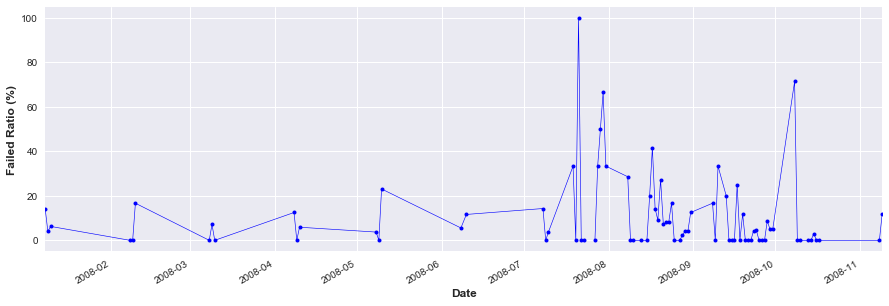

In [12]:
# Resampling yield data based on daily information 
failed_product = df2.L0[df2['L0']==1].resample('D').count()
total_product = df2.L0[df2['L0']==-1].resample('D').count()

failed_ratio = failed_product * 100 / total_product
failed_ratio = failed_ratio.dropna()

# Visualizaion of daily production failed ratio
sns.set()

failed_ratio.plot(style='bo-',MarkerSize=4, LineWidth = 0.6, figsize=(15,5))

plt.xlabel('Date', fontweight="bold", size=12)
plt.ylabel('Failed Ratio (%)', fontweight="bold", size=12)
plt.grid(True);plt.savefig('100Days.png')
plt.show()

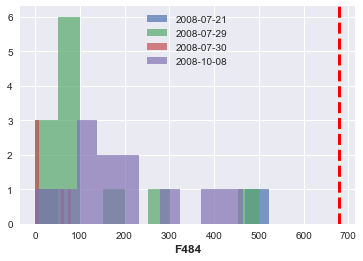

In [13]:
# Indexing dates with more than 50% failed ratio
date_index = failed_ratio[failed_ratio >= 50]

# Plotting F484 for date_index
df2['F484'].loc['2008-07-21'].hist(alpha=0.7, label = '2008-07-21')
df2['F484'].loc['2008-07-29'].hist(alpha=0.7, label = '2008-07-29')
df2['F484'].loc['2008-07-30'].hist(alpha=0.7, label = '2008-07-30')
df2['F484'].loc['2008-10-08'].hist(alpha=0.7, label = '2008-10-08')
plt.axvline(680, color='r', linestyle='dashed', linewidth=3) # Thresold in hypothesis testing (Previouse section)
plt.xlabel('F484', fontweight="bold", size=12)
plt.legend()
plt.show()


Result clearly illustrates that at none of these four days, F484 parameter passes 680 threshold (dash red line), recommended by hypothesis testing. Same analysis can be done for other category III parameters to bring better understanding of operation condition and its effect on yield efficiency.  
<br>
<br>

<a id="ID"></a>
### 6- Imbalanced Data
<div style="text-align: justify">
The fail/total ratio indicates that imbalanced representation of binary classes with only 6 % fail class (label=1). We split the data-set to training and test set. Common practice to address imbalance data is to perform under-sampling or over-sampling on training set, which can be simply done by using imblearn library (as shown below). Due to relatively small size of the entire data-set, employing more complex under or over sampling won't be beneficiary. Despite showing both under-sampling and over-sampling here, but we are going to use original training set in Machine Learning section. Because, Extreme Gradient Boosting method inherently boosts learning from under-represented data. <div>  

In [14]:
#########################################################
# Claculating default Ratio
passed = len(df[df['L0']==0])
failed = len(df[df['L0']==1])
ratio = float(failed/(passed+failed))
print('Number of passed sample:', passed)
print('Number of failed sample:', failed)
print('Default Ratio (failed/total) :', "%.3f" % ratio)

#########################################################
# Splitting data to train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=42)
X_test = X_test.as_matrix() # Coverting dataframe to matrix for compatibility purpose

# Under-sampling of overer-represented calss (pass) 
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_us, y_us = rus.fit_sample(X_train, y_train)

print('########################################')
print('Size of training data-set:', X_train.shape)
print('Size of under sampling data_set:', X_us.shape)

# Over-sampling of under-represented calss (fail)
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_os, y_os = ros.fit_sample(X_train, y_train)
print('Size of overer sampling data_set:', X_os.shape)

Number of passed sample: 1463
Number of failed sample: 104
Default Ratio (failed/total) : 0.066
########################################
Size of training data-set: (1096, 41)
Size of under sampling data_set: (146, 41)
Size of overer sampling data_set: (2046, 41)


<a id="MLMD"></a>
### 7- Machine Learning Model Development
<div style="text-align: justify">
Due to data-set anonymity, which makes outlier removal impossible and also considering imbalanced data, which makes learning process quite difficult, we decided to choose **Extreme Gradient Boosting** Machine learning technique to develop our predictive model. This technique is not susceptible to outliers and can perfectly handle both numerical and categorical features. It also boosts learning process from hard-to-learn samples by increasing their wight factor in every iteration, which becomes handy in imbalance data-set. For model optimization we followed <b>[AARSHAY JAIN](https://www.analyticsvidhya.com/blog/author/aarshay/)</b> guideline. The complete article can be found at this <b>[address](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)</b>.  <div> 

In [35]:
# Import ML Libraries 

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.metrics import classification_report
from matplotlib.pylab import rcParams
import warnings
warnings.filterwarnings('ignore')
#rcParams['figure.figsize'] = 12, 4

In [16]:
# XGB Model

def xgb_model(alg, X_matrix, y_vector, test_matrix, test_vector, useTrainCV=True, useTestSet = False, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_matrix, y_vector)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_matrix, y_vector, eval_metric='auc')   
    
    #Predict training set:
    dtrain_predictions = alg.predict(X_matrix)
    dtrain_predprob = alg.predict_proba(X_matrix)[:,1]
    #Print model report:
    print ("\nModel Report on Training Set")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_vector, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_vector, dtrain_predprob))
    # Determine the false positive and true positive rates
    fpr_train, tpr_train, _ = roc_curve(y_vector, dtrain_predprob)
    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr_train, tpr_train, label='Training ROC curve (area = %0.2f)' % metrics.roc_auc_score(y_vector, dtrain_predprob))
       
    ############################################################    
    if useTestSet:   
        #Predict test set:
        dtest_predictions = alg.predict(test_matrix)
        dtest_predprob = alg.predict_proba(test_matrix)[:,1] 
        #Print model report:
        print ("\nModel Report on Test Set")
        print ("Accuracy : %.4g" % metrics.accuracy_score(test_vector, dtest_predictions))
        print ("AUC Score (Test): %f" % metrics.roc_auc_score(test_vector, dtest_predprob))               
        # Determine the false positive and true positive rates
        fpr_test, tpr_test, _ = roc_curve(test_vector, dtest_predprob) 
        # Plot of a ROC curve for a specific class
        plt.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % metrics.roc_auc_score(test_vector, dtest_predprob))
              
    ############################################################    
    plt.plot([0, 1], [0, 1], 'k--'); plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05]);
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve')
    plt.legend(loc="lower right"); plt.show()

    
    ############################################################
    # Calculating feature importance
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
        


Model Report on Training Set
Accuracy : 0.9827
AUC Score (Train): 0.999987


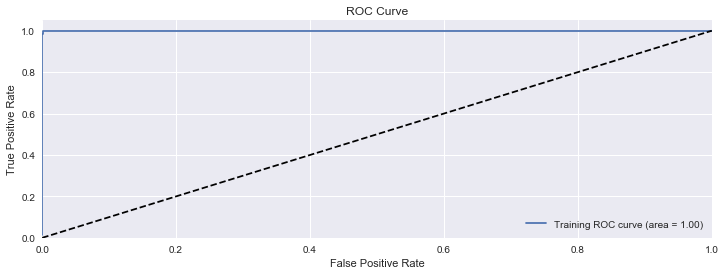

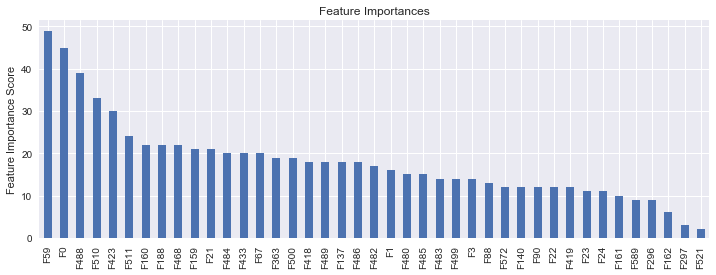

In [19]:
# First run with default model parameters 

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=200,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0,
 reg_lambda=1,     
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_model(xgb1, X_train, y_train, X_test, y_test)



<div style="text-align: justify">
Model preliminary result obviously shows over-fitting character as accuracy and ROC score are both close to one. Therefore, it is necessary to optimize model parameters to enhanced performance while avoiding over-fitting in final prediction.   

<div>

<a id="XGBMO"></a>
### 8- XGB Model Optimization
Here, we are going to fine-tune significant parameters of the model in order to achieve best performance while avoiding over-fitting. Step by step model optimization is listed as follows;

**1- max_depth:** The maximum depth of a tree[default=6] <br>
**2- min_child_weight:** Defines the minimum sum of weights of all observations required in a child [default=1]<br>
**3- gamma:**  Specifies the minimum loss reduction required to make a split  [default=0]<br>
**4- subsample:** Denotes the fraction of observations to be randomly samples for each tree [default=1]<br>
**5- colsample_bytree:** Denotes the fraction of columns to be randomly samples for each tree [default=1]<br>
**6- reg_alpha:** L1 regularization term on weight  [default=0]<br>
**7- reg_lambda:** L2 regularization term on weights [default=1]<br>

In [20]:
# Tunning max_depth & min_child_weight (Part I)

param_test1 = {
 'max_depth':np.arange(3,10,2),
 'min_child_weight':np.arange(1,10,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, reg_alpha=0, reg_lambda=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.67180, std: 0.03655, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.67679, std: 0.03936, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.67355, std: 0.05658, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.68278, std: 0.07298, params: {'max_depth': 3, 'min_child_weight': 7},
  mean: 0.68197, std: 0.07007, params: {'max_depth': 3, 'min_child_weight': 9},
  mean: 0.67705, std: 0.05476, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.67287, std: 0.04756, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.67861, std: 0.06110, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.68034, std: 0.07142, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: 0.68023, std: 0.06273, params: {'max_depth': 5, 'min_child_weight': 9},
  mean: 0.67089, std: 0.03985, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.66864, std: 0.05513, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.67479, std: 0.05439, params: {

In [23]:
# Tunning max_depth & min_child_weight (Part II)
param_test2 = {
 'max_depth':[6,7,8]
 }
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=200, max_depth=7,
 min_child_weight=9, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=0, reg_lambda=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.68310, std: 0.06298, params: {'max_depth': 6},
  mean: 0.68310, std: 0.06298, params: {'max_depth': 7},
  mean: 0.68310, std: 0.06298, params: {'max_depth': 8}],
 {'max_depth': 6},
 0.6830954430552709)

In [26]:
# Tunning max_depth & min_child_weight (Part III)
param_test3 = {
 'min_child_weight':[8,9,10,11,12,13,14,15,16]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=200, max_depth=6,
 min_child_weight=9, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.68436, std: 0.06544, params: {'min_child_weight': 8},
  mean: 0.68310, std: 0.06298, params: {'min_child_weight': 9},
  mean: 0.68889, std: 0.06844, params: {'min_child_weight': 10},
  mean: 0.68876, std: 0.06948, params: {'min_child_weight': 11},
  mean: 0.70778, std: 0.05779, params: {'min_child_weight': 12},
  mean: 0.71391, std: 0.06304, params: {'min_child_weight': 13},
  mean: 0.71489, std: 0.06570, params: {'min_child_weight': 14},
  mean: 0.71176, std: 0.06782, params: {'min_child_weight': 15},
  mean: 0.70115, std: 0.07337, params: {'min_child_weight': 16}],
 {'min_child_weight': 14},
 0.7148891166222586)

In [27]:
# Tunning gamma
param_test4 = {
 'gamma':[i/10.0 for i in range(0,8)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=6,
 min_child_weight=14, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=0, reg_lambda=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train, y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.71489, std: 0.06570, params: {'gamma': 0.0},
  mean: 0.71581, std: 0.06341, params: {'gamma': 0.1},
  mean: 0.71394, std: 0.06313, params: {'gamma': 0.2},
  mean: 0.71585, std: 0.06688, params: {'gamma': 0.3},
  mean: 0.72014, std: 0.06644, params: {'gamma': 0.4},
  mean: 0.71670, std: 0.06196, params: {'gamma': 0.5},
  mean: 0.71367, std: 0.06544, params: {'gamma': 0.6},
  mean: 0.71209, std: 0.06298, params: {'gamma': 0.7}],
 {'gamma': 0.4},
 0.7201366400218623)

In [28]:
# Tunning subsample & colsample_bytree (Part I)
param_test5 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=6,
 min_child_weight=14, gamma=0.4, subsample=0.8, colsample_bytree=0.8,reg_alpha=0, reg_lambda=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train, y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.69310, std: 0.07492, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.69772, std: 0.07015, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.71093, std: 0.07287, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.69943, std: 0.05891, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.68557, std: 0.08181, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.70442, std: 0.07229, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.71534, std: 0.07255, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.70174, std: 0.05737, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.68157, std: 0.08244, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.69792, std: 0.08052, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.72014, std: 0.06644, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.68996, std: 0.06360, params: {'colsample_bytree': 0.8, 'subsample'

In [29]:
# Tunning subsample & colsample_bytree (Part II)
param_test6 = {
 'subsample':[i/100.0 for i in range(70,95,5)],
 'colsample_bytree':[i/100.0 for i in range(70,95,5)]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=6,
 min_child_weight=14, gamma=0.4, subsample=0.8, colsample_bytree=0.8,reg_alpha=0, reg_lambda=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train, y_train)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.70442, std: 0.07229, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.70595, std: 0.07674, params: {'colsample_bytree': 0.7, 'subsample': 0.75},
  mean: 0.71534, std: 0.07255, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.70287, std: 0.07366, params: {'colsample_bytree': 0.7, 'subsample': 0.85},
  mean: 0.70174, std: 0.05737, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.70577, std: 0.07521, params: {'colsample_bytree': 0.75, 'subsample': 0.7},
  mean: 0.71331, std: 0.07268, params: {'colsample_bytree': 0.75, 'subsample': 0.75},
  mean: 0.72280, std: 0.06211, params: {'colsample_bytree': 0.75, 'subsample': 0.8},
  mean: 0.70558, std: 0.07463, params: {'colsample_bytree': 0.75, 'subsample': 0.85},
  mean: 0.69767, std: 0.05719, params: {'colsample_bytree': 0.75, 'subsample': 0.9},
  mean: 0.69792, std: 0.08052, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.71218, std: 0.07057, params: {'colsample_bytree': 0.8, 's

In [30]:
# Tunning reg_alpha
param_test7 = {
 'reg_alpha':[0.0, 0.1,0.2,0.3,0.4,0.5]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=6,
 min_child_weight=14, gamma=0.4, subsample=0.8, colsample_bytree=0.75,reg_alpha=0, reg_lambda=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X_train, y_train)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.72280, std: 0.06211, params: {'reg_alpha': 0.0},
  mean: 0.71624, std: 0.06752, params: {'reg_alpha': 0.1},
  mean: 0.72200, std: 0.05987, params: {'reg_alpha': 0.2},
  mean: 0.71681, std: 0.06546, params: {'reg_alpha': 0.3},
  mean: 0.72154, std: 0.05937, params: {'reg_alpha': 0.4},
  mean: 0.72393, std: 0.06003, params: {'reg_alpha': 0.5}],
 {'reg_alpha': 0.5},
 0.7239291521486644)

In [31]:
# Tunning reg_lambda
param_test8 = {
 'reg_lambda':[0.5,1,2]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=7,
 min_child_weight=14, gamma=0.4, subsample=0.8, colsample_bytree=0.75,reg_alpha=0.5, reg_lambda=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch8.fit(X_train, y_train)
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

([mean: 0.71707, std: 0.05935, params: {'reg_lambda': 0.5},
  mean: 0.72393, std: 0.06003, params: {'reg_lambda': 1},
  mean: 0.71888, std: 0.06249, params: {'reg_lambda': 2}],
 {'reg_lambda': 1},
 0.7239291521486644)

<br>


Parameter |  Value | ROC |
 :- |:-: | :-: |
 max_depth   | 6 | 0.683 |
min_child_weight   | 14 | 0.714 |
gamma  | 0.4 | 0.720 |
subsample  | 0.8 | 0.722|
colsample_bytree  | 0.75 | 0.722 |
reg_alpha  | 0.5 |0.723 |
reg_lambda  | 1 | 0.723 |

<br>
Table above shows final parameters and associated ROC score. As it is evidence, optimization is increased ROC scores from 0.68 to 0.72. The model is also regularized in order to avoid over-fitting. The optimized model is then used for final prediction on test set. 



In [33]:
X_train = X_train.as_matrix()


Model Report on Training Set
Accuracy : 0.9334
AUC Score (Train): 0.898204

Model Report on Test Set
Accuracy : 0.9342
AUC Score (Test): 0.745674


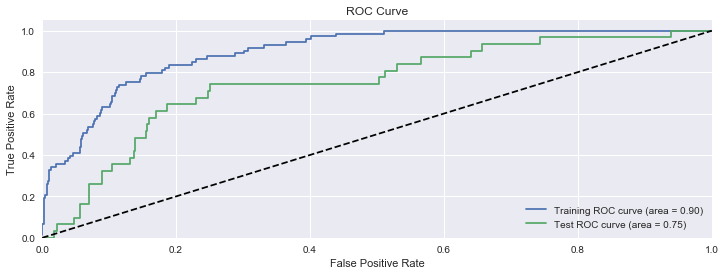

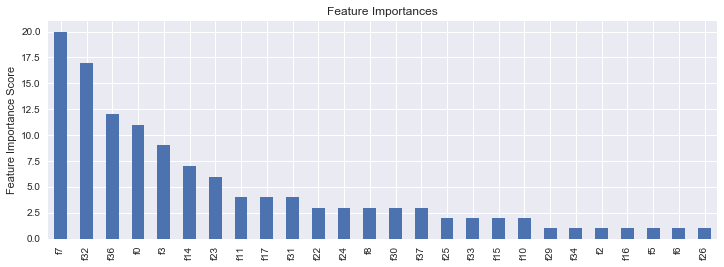

In [34]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=200,
 max_depth=7,
 min_child_weight=14,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.75,
 reg_alpha=0.5,
 reg_lambda=1,   
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_model(xgb2, X_train, y_train, X_test, y_test, useTestSet = True)

<div style="text-align: justify">
Final results show lower accuracy and ROC score in training set, which indicates regularization has effectively damped over-fitting while overall model performance  improved. Feature importance plot has also shown no feature associated with category II (Sec. 3), which confirms our argument regarding insignificant nature of this category of feature despite being picked by LASSO algorithm. <div>  

<a id="FN"></a>
### 9- Final Note:
<div style="text-align: justify">
In this work, **SECOM** data-set is under gone complete analysis in order to bring practical insight from collected data during semiconductor manufacturing process. Main findings of this analysis is summarized below:

1. High dimensional original data is reduced to only 41 significant features, which latter used for further analysis.<br>
2. After statistical hypothesis testing and time series analysis, number of features (F24, F88, F161, F483, F484) is recommended for process optimization and productivity enhancement.<br>
3. Data-driven model is developed based on **Extreme Gradient Boosting** method, in order to increase prediction power over operation. The model is also finely tuned and optimized for actual implementation.<br>
4. Final feature importance is provided based on prediction model which can be used by field expert to prioritize process control.



<div>